Copyright 2020-2022 Universidad Complutense de Madrid

This file software has been employed to calibrate infrared spectroscopic data from the EMIR instrument at GTC (see [Paliya et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L...8P/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), Nicolás Cardiel (cardiel@ucm.es) Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+ License-Filename: LICENSE.txt

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
mpl.rcParams['font.family'] = 'serif'

from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.interpolate import interp1d
from scipy import ndimage

import sys
sys.path.insert(1, '/Users/criscabe/SOFTWARE/boundfit/exec_boundfit')
from exec_boundfit import BoundaryDef
from exec_boundfit import SuperBoundary

from numina.array.wavecalib.crosscorrelation import compute_broadening
from scipy.ndimage.filters import gaussian_filter

# <span style="color:red">Generation of the response curve</span>  

## In this notebook, we proceed with the generation of the response curve for the flux calibration of EMIR spectroscopic data.

To carry out the flux calibration of the target spectrum, we observed the spectro-photometric standard star HD116405 with the same instrument setup (EMIR K-band long-slit mode). The reduction of the standard star was done using the PyEmir Data Reduction Pipeline (https://pyemir.readthedocs.io/en/latest/), and following the same procedure as for the target. 

We inspect the resulting 2D image and define the limits in the Y-axis (spatial direction) for the 1D spectrum extraction.

(2090, 3400)


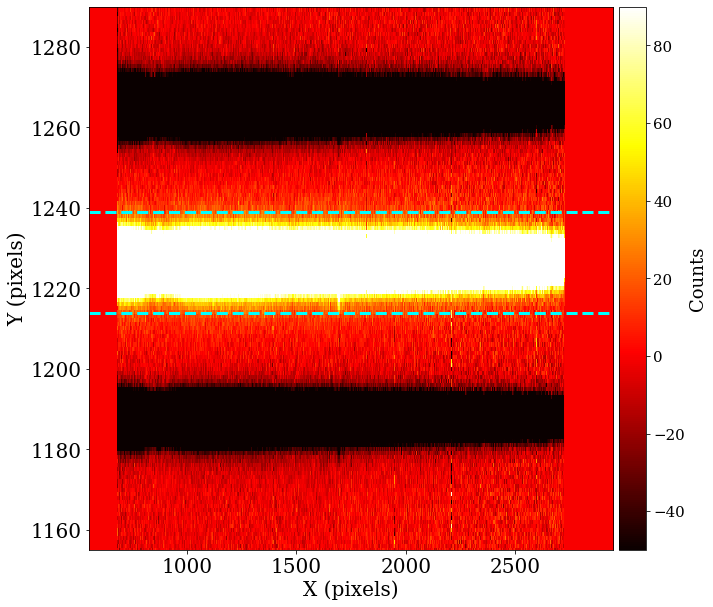

In [41]:
with fits.open('N2/reduced_mos_abba_combined.fits') as hdul:
    header = hdul[0].header
    data = hdul[0].data
naxis1 = header['naxis1']
naxis2 = header['naxis2']
print(data.shape)



fig, ax = plt.subplots(figsize=(10,10))
cmap = ax.imshow(data, cmap='hot', aspect='auto', interpolation='nearest',
                 origin='lower', vmin=-50, vmax= 90)
cb = plt.colorbar(cmap,fraction=0.05, pad=0.01) 
cb.ax.tick_params(labelsize=15)
cb.set_label('Counts', fontsize=18,family='serif')
ax.set_xlabel('X (pixels)', fontsize=20,family='serif')
ax.set_ylabel('Y (pixels)', fontsize=20,family='serif')
plt.yticks(fontname = 'serif', size=20)
plt.xticks(fontname = 'serif', size=20)
ax.axhline(1214, color='cyan', linestyle='dashed',linewidth=3)
ax.axhline(1239, color='cyan', linestyle='dashed',linewidth=3)
plt.xlim(550,2950)
plt.ylim(1155,1290)
plt.show()

Then, we extract the 1D spectrum of the spectro-photometric standard star HD116405 in units of ADUs/s.

In [42]:
ns1 = 1214
ns2 = 1239
sp = np.sum(data[ns1:ns2, :], axis=0)
print('Shape of the spectrum:', sp.shape)

crpix1 = header['crpix1']
crval1 = header['crval1']
cdelt1 = header['cdelt1']

exptime = header['EXPTIME']
print('EXPTIME: {}'.format(exptime))

sp = sp / exptime  # Spectrum in units of ADUs/s

wave = crval1 + (np.arange(naxis1)+1-crpix1)*cdelt1

print('cdelt1:', cdelt1) # Dispersion (angstrom/pixel)
print('crval1:', crval1) # Pixel 1
print('crpix1:', crpix1) # Wavelength 1

Shape of the spectrum: (3400,)
EXPTIME: 29.99926
cdelt1: 1.73
crval1: 19100.0
crpix1: 1.0


We plot the observed star spectrum. In addition, we also plot the telluric transmission spectrum which was computed with SkyCalc, a web application based on the Cerro Paranal Advanced Sky Model (https://www.eso.org/observing/etc/doc/skycalc/helpskycalc.html). We make sure that this telluric spectrum matches the wavelength range covered by the star spectrum, and we adjust its height.

In [43]:
telluric_tabulated = np.genfromtxt("skycalc_transmission_R20000.txt")
xtelluric = telluric_tabulated[:,0] * 10  # convert from nm to Angstrom
ytelluric = telluric_tabulated[:,1]

iok = np.argwhere(np.logical_and(xtelluric >= wave.min(), xtelluric <= wave.max())) # For the wavelength range
xtelluric = xtelluric[iok]
ytelluric = ytelluric[iok]
ytelluric = ytelluric / ytelluric.max() * 850 # For the Y values

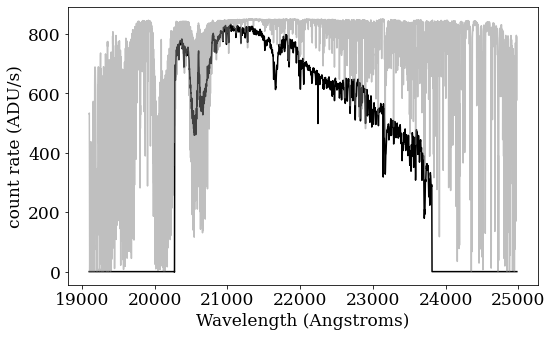

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, sp, 'k-')
ax.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.5)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('count rate (ADU/s)')
fig.tight_layout()

As shown in the figure, the star spectrum is affected by the atmospheric telluric absorptions.

We obtained the name of the standard star from the header information:

```
$ fitsheader reduced_mos_abba_combined.fits -k object 
# HDU 0 in reduced_mos_abba_combined.fits:
OBJECT  = 'HD116405'           / Object name 
```

The spectrophotometric standard HD116405 is available in CALSPEC (https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec)

We then load this file and have a look at the header info of the tabulated spectrum. 

In [45]:
with fits.open('N2/hd116405_stis_005.fits') as hdul:
    tbl = hdul[1].data

print(tbl.shape)

(7206,)


In [46]:
hdul.info()

Filename: N2/hd116405_stis_005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   ()      
  1  SCI           1 BinTableHDU     39   7206R x 7C   [1D, 1E, 1E, 1E, 1E, 1I, 1E]   


In [47]:
print(hdul[1].columns)

ColDefs(
    name = 'WAVELENGTH'; format = '1D'; unit = 'ANGSTROMS'; disp = 'G10.4'
    name = 'FLUX'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'STATERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'SYSERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'FWHM'; format = '1E'; unit = 'ANGSTROMS'; disp = 'G6.2'
    name = 'DATAQUAL'; format = '1I'; unit = 'NONE'; disp = 'I2'
    name = 'TOTEXP'; format = '1E'; unit = 'SEC'; disp = 'G10.2'
)


In [48]:
stds_table = Table(tbl)
stds_table

WAVELENGTH,FLUX,STATERROR,SYSERROR,FWHM,DATAQUAL,TOTEXP
float64,float32,float32,float32,float32,int16,float32
1140.2705078125,1.9158e-12,9.7445e-14,1.9158e-14,1.1673582,1,640.0
1140.854248,1.8751e-12,8.6834e-14,1.8751e-14,1.1673582,1,640.0
1141.437866,1.8051e-12,7.9799e-14,1.8051e-14,1.167358,1,640.0
1142.021606,1.9296e-12,7.2929e-14,1.9296e-14,1.167359,1,640.0
1142.605225,1.9025e-12,6.9021e-14,1.9025e-14,1.167359,1,640.0
1143.188965,1.9673e-12,6.2346e-14,1.9673e-14,1.167358,1,640.0
1143.772583,2.1577e-12,6.1236e-14,2.1577e-14,1.167358,1,640.0
1144.356323,1.9928e-12,5.511e-14,1.9928e-14,1.167358,1,640.0
1144.939941,1.907e-12,4.9141e-14,1.907e-14,1.167359,1,640.0


Next, we extract the wavelength and the flux of the tabulated spectrum of HD116405.

We perform a linear 1D interpolation to obtain the tabulated fluxes for the wavelength values within the wavelength range covered by our observed spectrum.


We compare the observed (blue) and tabulated (dark red) spectra of HD116405. The telluric absorptions are marked in gray.

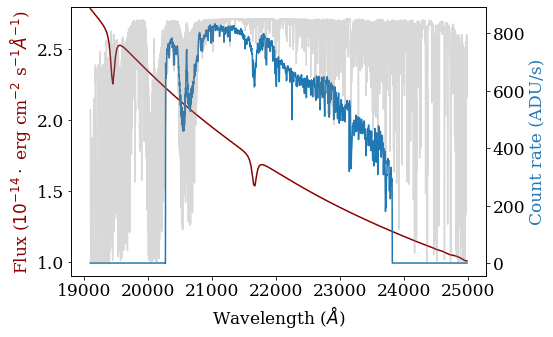

In [49]:
stds_wave = np.array(stds_table['WAVELENGTH'])
stds_flam = np.array(stds_table['FLUX'])

funflam = interp1d(stds_wave, stds_flam, kind='linear')
flam = funflam(wave)



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, flam*10**(14), color='darkred')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel(r'Flux ($10^{-14} \cdot$ erg cm$^{-2}$ s$^{-1} \AA^{-1}$)', color='darkred')
ax.set_ylim(0.9,2.8)
ax2 = ax.twinx()
ax2.plot(wave, sp, '-', color='C0')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.3)
fig.tight_layout()
fig.savefig('Standard_star_tab_vs_obs.pdf', bbox_inches='tight')

Now we are going to check the broadness of the absorptions, which should be the same in the observed and tabulated spectrum. First, we normalized the spectra and plotted them by zooming on a region with a strong absorption feature. 

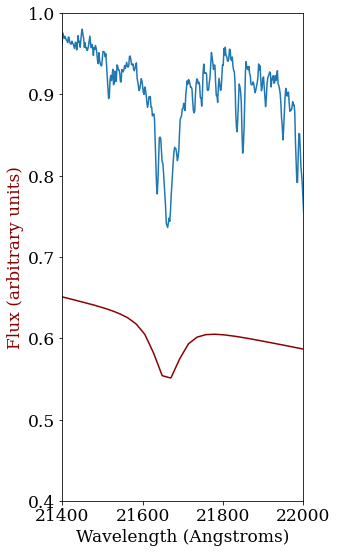

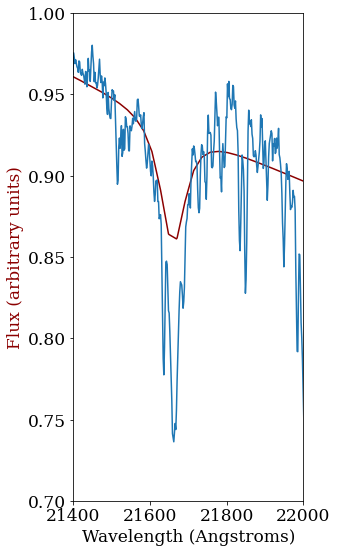

In [50]:
flam_norm = flam / flam.max()
sp_norm = sp / sp.max()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,8))
ax.plot(wave, flam_norm, color='darkred')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel(r'Flux (arbitrary units)', color='darkred')
ax.plot(wave, sp_norm, '-')
ax.set_xlim(21400,22000)
ax.set_ylim(0.4,1)
fig.tight_layout()

# we shift the tabulated spectrum

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,8))
ax.plot(wave, flam_norm+0.31, color='darkred')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel(r'Flux (arbitrary units)', color='darkred')
ax.plot(wave, sp_norm, '-')
ax.set_xlim(21400,22000)
ax.set_ylim(0.7,1)
fig.tight_layout()

Although apparently, the broadness is the same, we computed the sigma value using the cross-correlation technique.

The value of sigma is:  0
The offset between spectra (in Angstroms) is:  -0.6084875683810759


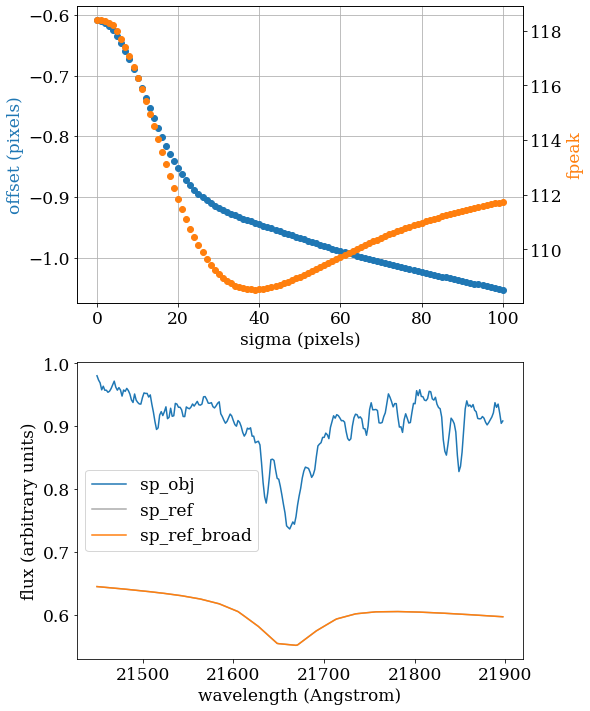

In [51]:
# Selection of a region with a strong absorption feature in pixels (whole numbers)

lambdas = np.array([21450,21900])
npixels = (lambdas - np.float(crval1)) / np.float(cdelt1)
npix1 = int(npixels[0] + 0.5)
npix2 = int(npixels[1] + 0.5)

# Compute cross-correllation

fig, axarr = plt.subplots(2,1, figsize = (8,12))
offset_broad, sigma_broad, final_spectrum_broad = compute_broadening(
    wv_obj = wave[npix1:npix2] , sp_obj = sp_norm[npix1:npix2],
    wv_ref = wave[npix1:npix2] , sp_ref = flam_norm[npix1:npix2] ,
    sigmalist = np.arange(0,101,1),
    remove_mean = False,
    frac_cosbell = 0.01,
    zero_padding = 90,
    fminmax = (0.01, 0.015),
    naround_zero = 10,
    nfit_peak = 51,
    ax1 = axarr[0], ax2 = axarr[1],
    debugplot = 0
)
axarr[0].grid()


print('The value of sigma is: ', sigma_broad)
print('The offset between spectra (in Angstroms) is: ', offset_broad)

We found that the value of sigma is zero, which implies that the broadness is the same.
Only in the case that sigma is higher than zero, we will use this sigma value to widen the spectrum with a Gaussian filter.

We also found that the offset between the spectra is -0.61 Angstroms, which corresponds to less than half of a pixel.

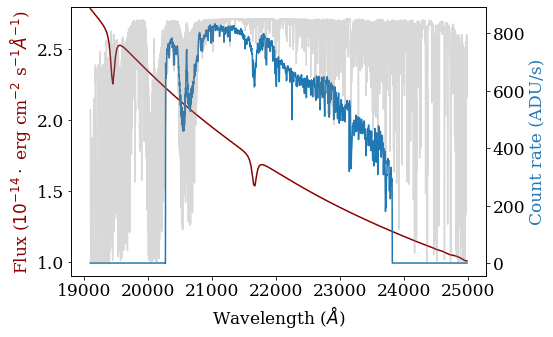

In [52]:
sigma_tab = sigma_broad  
if sigma_tab > 0:
    sp = gaussian_filter(sp, sigma_tab)
    
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, flam*10**(14), color='darkred')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel(r'Flux ($10^{-14} \cdot$ erg cm$^{-2}$ s$^{-1} \AA^{-1}$)', color='darkred')
ax.set_ylim(0.9,2.8)
ax2 = ax.twinx()
ax2.plot(wave, sp, '-', color='C0')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.3)
fig.tight_layout()
    

The spectral feature shown in the two spectra corresponds with Brackett $\gamma$ at 2.166~$\mu$m. We checked that this absorption presents the same broadness in both spectra, and then the response curve is computed by dividing the observed spectrum by the tabulated spectrum. 

We plot the observed spectrum (blue) and the derived response curve (black). The telluric absorptions are marked in gray.

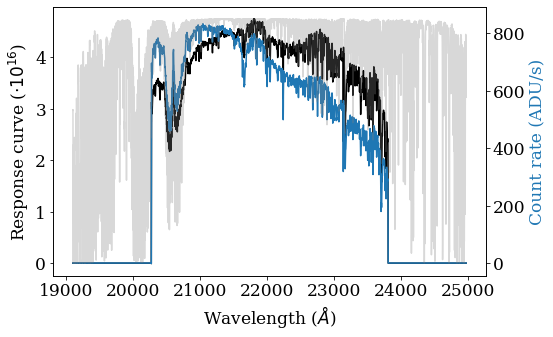

In [53]:
response = sp / flam


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, response*10**(-16), 'k-')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Response curve ($\cdot 10^{16}$)')
ax2 = ax.twinx()
ax2.plot(wave, sp, '-', color='C0')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.3)
fig.tight_layout()

The response curve presents several absorptions which allows us to perform the flux calibration as well as the telluric correction. 

However, we used the package **boundfit** (https://boundfit.readthedocs.io/en/latest/) (see [Cardiel 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.396..680C/abstract)) to fit an upper boundary of the stellar continuum and thus derive a telluric correction which takes into account the depth of the absorptions. The correction of this depth is very important when the target and the standard star are observed at different airmasses.

The wavelength range was divided into different subintervals, which were independently fitted. 
In particular, we fitted adaptive splines in different wavelength ranges by changing the positions of the knots in an iterative process.

The _'BoundaryDef'_ function allows us to select the individual regions in order to apply different degrees of freedom to each particular fit according to the variability exhibited by the local continuum. We defined the minimum and maximum wavelength, the number of knots used in the fit, and refined their position.

These individual fits are automatically averaged in the overlapping regions to provide an overall piecewise function thanks to the _'SuperBoundary'_ function.

In [54]:
# We create a list with the individual fits

def list_of_br(itype=0):
    lbr = []
    if itype == 0:
        lbr.append(BoundaryDef(xminfit=20290, xminuseful=20200, xmaxfit=21870, knots=3, rigidity=0.05, crefine='XY'))
        lbr.append(BoundaryDef(xminfit=21800, xmaxfit=22850, knots=7, crefine='XY'))
        lbr.append(BoundaryDef(xminfit=22750, xmaxfit=23700, knots=7, crefine='XY'))
        lbr.append(BoundaryDef(xminfit=23600, xmaxfit=23800, xmaxuseful=24000, knots=3, crefine='XY'))
    else:
        lbr.append(BoundaryDef(xminfit=20200, xmaxfit=24000, knots=0)) # knots = 0 will return the original data
    return lbr

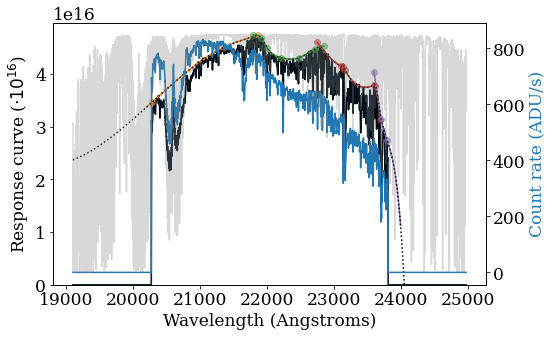

In [55]:
xfactor = 1E-4               # Normalization factor in the X axis
yfactor = 1/response.max()   # Normalization factor in the Y axis
medfiltwidth=1  # Width of the median filter to smooth the noise 


# boundfit allows fitting the continuum without being affected by telluric absorptions 
# continuum1 corresponds with the upper boundary of the stellar continuum.

continuum1 = SuperBoundary(
    xfit=wave,
    yfit=response,
    listboundregions=list_of_br(0),
    xfactor=xfactor,
    yfactor=yfactor,
    medfiltwidth=medfiltwidth
)

# In this case, continuum2 corresponds with the response curve because the number of knots was set to zero

continuum2 = SuperBoundary(
    xfit=wave,
    yfit=response,
    listboundregions=list_of_br(1),
    xfactor=xfactor,
    yfactor=yfactor,
    medfiltwidth=medfiltwidth
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, response, 'k-')
ymin, ymax = ax.set_ylim()
ax.set_ylim([0, ymax])
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Response curve')
continuum1.plot(ax=ax, xlabel='Wavelength (Angstroms)', ylabel='Response curve ($\cdot 10^{16}$)')
ax.get_legend().remove()
ax2 = ax.twinx()
ax2.plot(wave, sp, '-', color='C0')
ax2.set_ylabel('Count rate (ADU/s)', color='C0')
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.3)
fig.tight_layout()

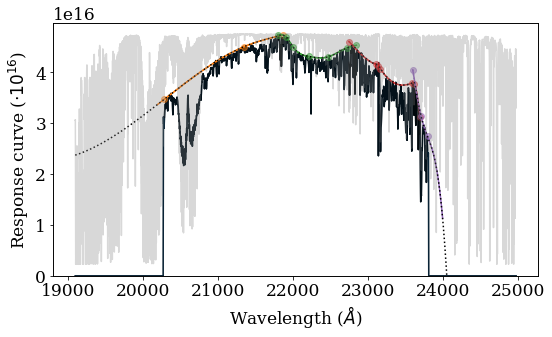

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, response, 'k-')
ymin, ymax = ax.set_ylim()
ax.set_ylim([0, ymax])
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Response curve')
continuum1.plot(ax=ax, xlabel='Wavelength ($\AA$)', ylabel='Response curve ($\cdot 10^{16}$)')
ax.get_legend().remove()
ax2 = ax.twinx()
ax2.plot(xtelluric, ytelluric, '-', color='gray', alpha=0.3)
ax2.set_yticks([ ])
fig.tight_layout()
fig.savefig('Standard_star_boundfit.pdf', bbox_inches='tight')

The fit to the stellar continuum corresponds with the variable **continuum1** (dotted line with different colors depending on the spectral region).

The response curve is **continuum2** (black line).


The normalized telluric absorption spectrum is computed as **continuum2** / **continuum1** (green line).

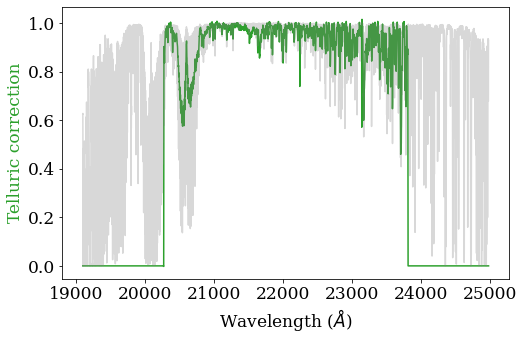

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(wave, continuum2.yboundary/continuum1.yboundary, 'C2')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Telluric correction', color='C2')
ax.plot(xtelluric, ytelluric/850, '-', color='gray', alpha=0.3)
fig.savefig('Standard_star_telluric_correction.pdf', bbox_inches='tight')

Finally, we save the txt file with the wavelength, the response curve, and the continuum boundaries derived with **boundfit**. 

In [14]:
with open('response.txt', 'tw') as f:
    for x, y1, y2, y3 in zip(wave, response, continuum1.yboundary, continuum2.yboundary):
        if y1 < 0:
            y1 = 0
        if y2 < 0:
            y2 = 0
        if y3 < 0:
            y3 = 0
        f.write('{:9.4f}  {:e}  {:e}  {:e}\n'.format(x, y1, y2, y3))